In [57]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from keras import layers, Model
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers, layers, losses
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import precision_recall_curve, confusion_matrix
from keras.utils import plot_model
import pandas as pd
import seaborn as sns

(39000, 14)


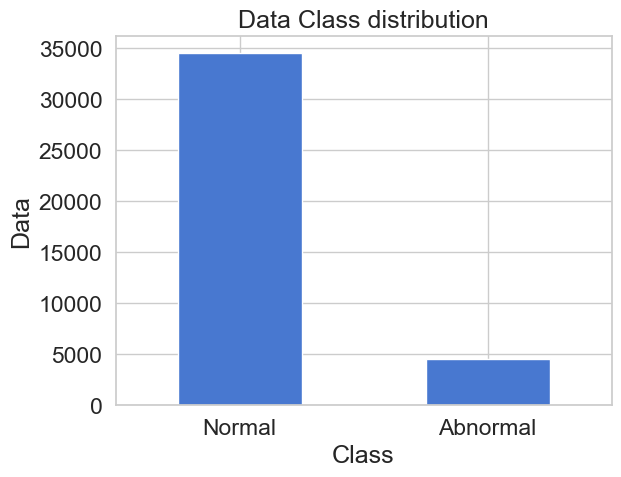

In [67]:
# Generate some sample data for the autoencoder
# x_train = np.random.rand(1000, 12)
# x_test = np.random.rand(100, 12)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

RANDOM_SEED = 42

df = pd.read_csv("Autoencoder1.csv")  
print(df.shape)

LABELS = ["Normal", "Abnormal"]

count_classes =pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Data Class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Data")
plt.show();

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from cmath import pi

data = df.drop(['Time'], axis=1)
y_true = df['Class']

r2d = 180/pi

data['P'] = r2d * data['P']
data['Q'] = r2d * data['Q']
data['R'] = r2d * data['R']
data['Phi'] = r2d * data['Phi']
data['Theta'] = r2d * data['Theta']
data['Psi'] = r2d * data['Psi']

In [28]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
y_train = X_train['Class']
X_train = pd.DataFrame(X_train)
X_train = X_train.drop(['Class'], axis=1)

# X_test = X_test[X_test.Class == 0]
y_test = X_test['Class']
X_test = pd.DataFrame(X_test)
X_test = X_test.drop(['Class'], axis=1)

def normalize(label):
    str = StandardScaler()
    str.fit(X_train[label].values.reshape(-1, 1))
    X_train[label] = str.transform(X_train[label].values.reshape(-1, 1))
    X_test[label] = str.transform(X_test[label].values.reshape(-1, 1))

def normalize1(label):
    str = MinMaxScaler()
    str.fit(X_train[label].values.reshape(-1, 1))
    X_train[label] = str.transform(X_train[label].values.reshape(-1, 1))
    X_test[label] = str.transform(X_test[label].values.reshape(-1, 1))

A = ['RPM1', 'RPM2', 'RPM3', 'RPM4', 'RPM5', 'RPM6', 'P', 'Q', 'R', 'Phi', 'Theta', 'Psi']

for i in A:
    normalize1(i)

X_train = X_train.values
X_test = X_test.values

In [29]:
input_dim = 12
latent_dim = 4

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            layers.Dense(8, activation='sigmoid',
                        activity_regularizer=regularizers.l2(10e-3)),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = Sequential([
            layers.Dense(8, activation='relu'),
            layers.Dense(input_dim, activation='tanh'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/5
   1/3625 [..............................] - ETA: 22:25 - loss: 0.2408

2023-02-17 15:50:40.064997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3625/3625 [==============================] - ETA: 0s - loss: 0.0402

2023-02-17 15:50:56.610777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: DAGMM/assets
3625/3625 [==============================] - 23s 6ms/step - loss: 0.0402 - val_loss: 0.0197
Epoch 2/5
3625/3625 [==============================] - 22s 6ms/step - loss: 0.0181 - val_loss: 0.0165
Epoch 3/5
3625/3625 [==============================] - 22s 6ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 4/5
3625/3625 [==============================] - 22s 6ms/step - loss: 0.0151 - val_loss: 0.0147
Epoch 5/5
3625/3625 [==============================] - 22s 6ms/step - loss: 0.0144 - val_loss: 0.0142
Model: "autoencoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 4)                 140       
                                                                 
 sequential_3 (Sequential)   (None, 12)                148       
                                                                 
Total params: 288
Trainable param

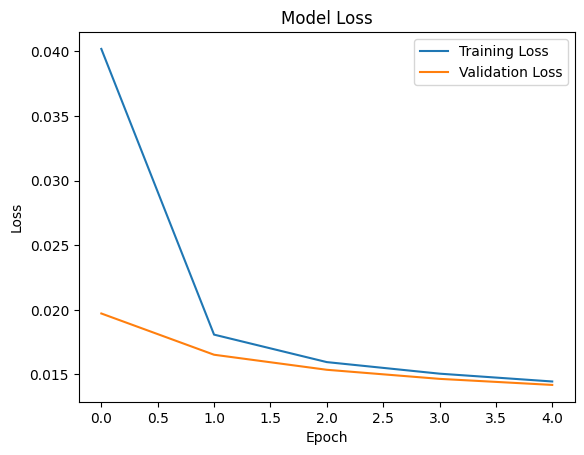

In [30]:
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
callback = EarlyStopping(monitor='val_loss', patience=3)
checkpointer = ModelCheckpoint(filepath="DAGMM",
                               monitor='val_loss',
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

batch_size = 4
nb_epochs = 5
history = autoencoder.fit(X_train, X_train,
                        epochs=nb_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.4,
                        callbacks=[checkpointer, tensorboard]).history

autoencoder.summary()

plt.plot(range(nb_epochs), history['loss'], label='Training Loss')
plt.plot(range(nb_epochs), history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# # Define the input layer for the autoencoder
# input_layer = Input(shape=(12,))

# # Define the encoder layers
# encoded = layers.Dense(8, activation='sigmoid')(input_layer)
# encoded = layers.Dense(4, activation='relu')(encoded)

# # Define the decoder layers
# decoded = layers.Dense(8, activation='relu')(encoded)
# decoded = layers.Dense(12, activation='tanh')(decoded)

# # Create the autoencoder model
# autoencoder = Model(input_layer, decoded)

# Compile the model
# autoencoder.compile(optimizer='adam', loss='mse')

# # Plot the model structure
# plot_model(autoencoder, to_file='DAGMM.png', show_shapes=True, show_layer_names=True)

# # Train the model
# history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(x_test, x_test))

# Plot the model loss
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [31]:
# Use the trained autoencoder to encode the training data
encoded_data = autoencoder.encoder(X_train).numpy()

# Fit a Gaussian Mixture Model with 2 components to the encoded training data
gmm = GaussianMixture(n_components=1)
gmm.fit(encoded_data)

GaussianMixture()

In [50]:
# Use the GMM to predict the probability densities for the encoded test data
encoded_test_data = autoencoder.encoder(X_test).numpy()
scores = gmm.score_samples(encoded_test_data) # score_samples: PDF of the test data

# Identify anomalies based on the GMM probability densities
threshold = np.percentile(scores, 11.5)
anomalies = X_test[scores < threshold]
print("scores :", scores)
print("threshold :", threshold)
print("anomalies :", anomalies)
print("scores < threshold :", scores < threshold)

scores : [  14.55068077   13.43661995 -880.5690804  ... -899.84324019   14.52775094
   13.19592328]
threshold : 5.0073992108537535
anomalies : [[ 2.11539347e-01  4.85686393e-01  7.27976121e-01 ... -3.48574832e+00
   4.37398851e-01 -1.71779201e+01]
 [ 5.87153269e-02  4.21239625e-01  8.05873035e-01 ...  4.86389554e-01
   4.05856415e-01  1.24688697e+01]
 [ 3.78747430e-01  1.15744756e-01  2.21431157e-01 ... -8.58945877e-01
   8.22963704e-01  1.43450058e+02]
 ...
 [ 3.50099262e-01  1.43091601e-01  2.73748374e-01 ...  5.07334013e-01
   5.16154033e-01  1.36288758e+02]
 [ 3.51043585e-01  9.03234096e-01  9.99999976e-01 ... -3.00923420e+00
   5.16154033e-01 -5.43163815e+02]
 [ 3.60623079e-01  1.33045822e-01  2.54529806e-01 ...  5.07334013e-01
   5.16154033e-01  1.39399123e+02]]
scores < threshold : [False False  True ...  True False False]


Precision: 0.9993, Recall: 0.9897, F1 score: 0.9945


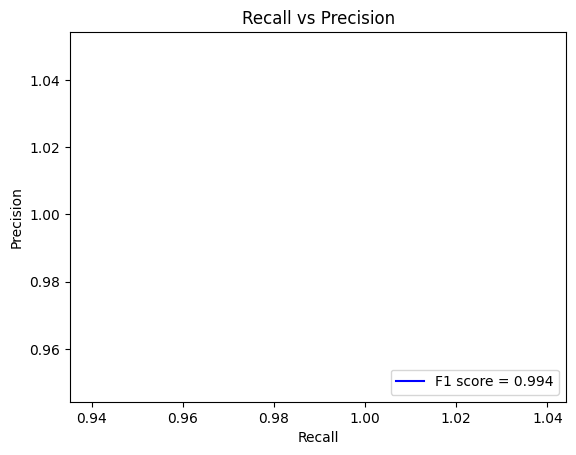

In [52]:
# Calculate precision, recall, and F1 score
y_pred = np.zeros_like(scores)
y_pred[scores < threshold] = 1
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}")

# precision recall curve
plt.figure()
plt.plot(recall, precision, 'b', label='F1 score = %0.3f'% f1)
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show();

In [ ]:
# Calculate precision, recall, and F1 score
y_true = np.zeros_like(scores)
y_true[scores < threshold] = 1
y_pred = np.zeros_like(scores)
y_pred[scores < threshold] = 1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}")

# Generate precision-recall curve with F1 score
precision, recall, thresholds = precision_recall_curve(y_true, scores)
f1_scores = 2 * precision * recall / (precision + recall)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.plot(recall, f1_scores, label='F1 score')
plt.xlabel('Recall')
plt.ylabel('Precision/F1 score')
plt.legend()
plt.show()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Generate score with threshold graph
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()